In [1]:
import sys, os, string
import numpy as np
from datetime import datetime
import time

In [2]:
# Perfect phylogeny

def perfectPhylogeny(m):
    m_prime = get_m_prime(m)
    (k, features) = get_k_matrix_features(m_prime)
    locations = []
    for feature in features:
        present_at = set([])
        for k_i in k:
            [ present_at.add(loc_list) for loc_list in list(np.where(k_i==feature)[0]) ]
        locations.append(list(present_at))

    loc_test = np.array([len(loc_list)>1 for loc_list in locations])
#     real_location_len = np.sum([len(loc) for loc in locations])
    if np.any(loc_test):
#         print('No phylogeny found!')
#         if len(loc_test)/real_location_len > 1:
#             raise ValueError('Perfect phylogeny algorithm went wrong')
        return (False, 1 - np.sum(loc_test)/len(loc_test))
#         return (False, len(loc_test)/real_location_len)
    else:    
#         print('Success! Found phylogeny!')
        return (True, 1)
    
def get_m_prime(m):
    # rotate M for convenient iteration
    m_prime = np.rot90(m)

    # keep only unique combinations
    m_prime = np.unique(list(map(lambda x: '.'.join(map(str, x)), m_prime)))
    m_prime = np.array(list(map(lambda x: list(map(int, x.split('.'))), m_prime)))

    # count binary score of columns
    binary_strings = []
    for col in m_prime:
        col_string = '0b'+''.join(map(str, col))
        binary_strings.append(int(col_string, 2))

    # sort by binary score
    order = np.argsort(binary_strings)[::-1]
    m_prime = m_prime[order] 

    m_prime = np.rot90(m_prime[:,:])[::-1] #rotate again
    return m_prime

def get_k_matrix_features(m_prime):
    ncol = len(m_prime[0])
    k = np.empty([0, ncol], dtype='<U2')
    features = random_seq(ncol)

    for m in m_prime:
        row_feats = features[m!=0] #features in the row
        mrow = np.zeros(ncol, dtype='<U2')
        mrow.fill('0')

        for idx,feature in enumerate(row_feats):
            mrow[idx] = feature

        n_feat = len(row_feats)    
        if n_feat < ncol: 
            mrow[n_feat]='#'

        k = np.append(k,[mrow],axis=0)

    return (k, features)

def random_seq(n):
    return np.array([rand_mutation_name(i) for i in range(0, n)])

def rand_mutation_name(i):
    i_0 = int(i / 26)
    i_1 = i % 26
    # Takes random choices from  
    # ascii_letters and digits  
    generate_pass = ''.join(string.ascii_lowercase[i_0] + string.ascii_lowercase[i_1])  
                            
    return generate_pass

In [3]:
m = np.array([[1, 1, 0, 1, 0, 1, 1],
              [1, 1, 0, 0, 0, 0, 1],
              [0, 1, 1, 1, 1, 0, 0],
              [1, 0, 0, 0, 1, 1, 0]])

a, d = perfectPhylogeny(m)
a, d

(False, 0.5714285714285714)

In [4]:
import random

from deap import base
from deap import creator
from deap import tools

In [5]:
# I - input matrix
# E - expected matrix
# i, e - elements from corresponding matrix
# alpha - false negative
# beta - false positive

def P(i, e, alpha=0, beta=0):
    if i == e == 0: return 1 - beta
    if i == 1 and e == 0: return beta
    if i == e == 1: return 1 - alpha
    if i == 0 and e == 1: return alpha
    
vp = np.vectorize(P)

def likelihood(I, E):
    return np.sum(vp(I, E))

In [6]:
def model(n, m, INPUT_MATRIX):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()

    # Attribute generator 
    #                      define 'attr_bool' to be an attribute ('gene')
    #                      which corresponds to integers sampled uniformly
    #                      from the range [0,1] (i.e. 0 or 1 with equal
    #                      probability)
    toolbox.register("attr_bool", random.randint, 0, 1)

    # Structure initializers
    #                         define 'individual' to be an individual
    #                         consisting of 100 'attr_bool' elements ('genes')
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
        toolbox.attr_bool, n*m)

    # define the population to be a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    def fitness(individual):
        return (likelihood(individual, INPUT_MATRIX)/(n*m),)

    def feasible(individual):
        """Feasability function for the individual. Returns True if feasible False
        otherwise."""
        i_matrix = np.array(individual).reshape(n, m)
        pf, _ = perfectPhylogeny(i_matrix)
        return pf
    
    def distance(individual):
        """A distance function to the feasability region."""
        i_matrix = np.array(individual).reshape(n, m)
        _, d = perfectPhylogeny(i_matrix)
        return likelihood(individual, INPUT_MATRIX)/(n*m) - (1 - d)

    #----------
    # Operator registration
    #----------
    # register the goal / fitness function
    toolbox.register("evaluate", fitness)
    toolbox.decorate("evaluate", tools.DeltaPenality(feasible, 0, distance))

    # register the crossover operator
    toolbox.register("mate", tools.cxTwoPoint)

    # register a mutation operator with a probability to
    # flip each attribute/gene of 0.05
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

    # operator for selecting individuals for breeding the next
    # generation: each individual of the current generation
    # is replaced by the 'fittest' (best) of three individuals
    # drawn randomly from the current generation.
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

In [7]:
def main(INPUT_MATRIX, stats=[]):
    start_time = time.time()
    random.seed(64)
    
    n, m = INPUT_MATRIX.shape
    toolbox = model(n, m, INPUT_MATRIX.reshape(n*m))

    # create an initial population of 300 individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=1000)

    # CXPB  is the probability with which two individuals
    #       are crossed
    #
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.5, 0.2
   
    print("n: %s, m: %s" % (n, m))
    print("Start of evolution")
    
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while max(fits) < 0.9 and g <= 503:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        
        if g % 10 == 0:
            max_list = np.unique([stat[1] for stat in stats[-5:]])
            if len(max_list) == 1:
                print('Increase MUTPB')
                MUTPB = 0.4
            else:
                print('Decrease MUTPB')
                MUTPB = 0.2
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        maxf = max(fits)
        minf = min(fits)
        
        stats.append([minf, maxf, mean, std])
        
        print("  Min %s" % minf)
        print("  Max %s" % maxf)
        print("  Avg %s" % mean)
        print("  Std %s" % std)
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    print("--- %s seconds ---" % (time.time() - start_time))

In [8]:
stats = []

INPUT_MATRIX = np.array([[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

main(INPUT_MATRIX, stats)

n: 20, m: 20
Start of evolution
  Evaluated 1000 individuals
-- Generation 1 --
  Evaluated 611 individuals
  Min 0.38250000000000006
  Max 0.5474999999999999
  Avg 0.4718598684210529
  Std 0.021038673322972316
-- Generation 2 --
  Evaluated 591 individuals
  Min 0.41250000000000003
  Max 0.5525
  Avg 0.4890400000000018
  Std 0.01908738850650486
-- Generation 3 --
  Evaluated 592 individuals
  Min 0.4375
  Max 0.5525
  Avg 0.5038449999999995
  Std 0.018248040305730327
-- Generation 4 --
  Evaluated 600 individuals
  Min 0.445
  Max 0.5774999999999999
  Avg 0.5171574999999975
  Std 0.01702208693878294
-- Generation 5 --
  Evaluated 616 individuals
  Min 0.4525
  Max 0.595
  Avg 0.5293073684210524
  Std 0.017514417440578793
-- Generation 6 --
  Evaluated 577 individuals
  Min 0.465
  Max 0.6
  Avg 0.5415175000000024
  Std 0.016853885123256702
-- Generation 7 --
  Evaluated 592 individuals
  Min 0.455
  Max 0.6074999999999999
  Avg 0.5537000000000014
  Std 0.017793538152922127
-- Generati

  Evaluated 615 individuals
  Min 0.705
  Max 0.865
  Avg 0.8410653362573106
  Std 0.027245094622011502
-- Generation 63 --
  Evaluated 596 individuals
  Min 0.705
  Max 0.8674999999999999
  Avg 0.8425397368421045
  Std 0.027840604997712577
-- Generation 64 --
  Evaluated 592 individuals
  Min 0.7175
  Max 0.87
  Avg 0.8451784210526296
  Std 0.026047893396986176
-- Generation 65 --
  Evaluated 611 individuals
  Min 0.72
  Max 0.87
  Avg 0.8466598684210511
  Std 0.027065558162155525
-- Generation 66 --
  Evaluated 579 individuals
  Min 0.715
  Max 0.8724999999999999
  Avg 0.8491590789473676
  Std 0.025634521783122272
-- Generation 67 --
  Evaluated 604 individuals
  Min 0.7224999999999999
  Max 0.875
  Avg 0.8499564473684197
  Std 0.026315318890284222
-- Generation 68 --
  Evaluated 577 individuals
  Min 0.74
  Max 0.8775
  Avg 0.8533496052631565
  Std 0.02469322377499035
-- Generation 69 --
  Evaluated 638 individuals
  Min 0.71
  Max 0.8775
  Avg 0.8556365789473648
  Std 0.02522276161

In [9]:
min_list = np.array([stat[0] for stat in stats])
max_list = np.array([stat[1] for stat in stats])
avg_list = np.array([stat[2] for stat in stats])
std_list = np.array([stat[3] for stat in stats])

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

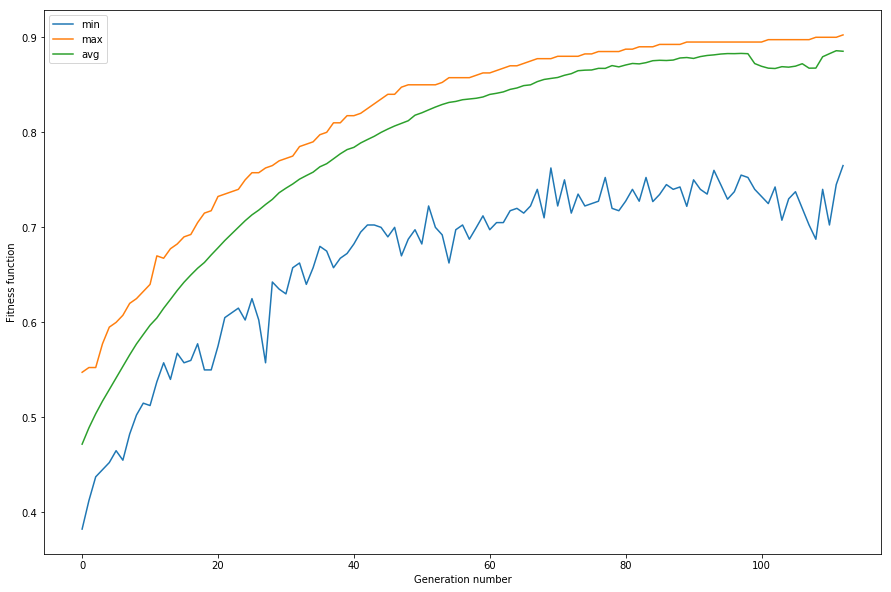

In [13]:
x = np.arange(0, len(stats), 1)

plt.plot(x, min_list, label='min')
plt.plot(x, max_list, label='max')
plt.plot(x, avg_list, label='avg')

plt.xlabel('Generation number')
plt.ylabel('Fitness function')

plt.legend()
plt.show()